# Basic Example : How to construct $G_0$ from QSGW Hamiltonian

$$G^0(\omega,L,L') = \sum_{kij} P^{LL'}_{kij} \frac{\delta_{ij}}{\omega - \epsilon_{ik} }$$

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pytriqs.lattice import BrillouinZone, BravaisLattice
from pytriqs.gf import *
from pytriqs.gf.tools import *
import numpy as np
import h5py

# Parameters

In [23]:
beta = 100
nomg = 1000
cix  = 0
DC = 24.3


# Load Questaal data

In [24]:
# read useful information
fh5 = h5py.File('h_lm.h5', 'r')
nsp = np.array(fh5['nsp'])[0]
alat = np.array(fh5['alat']) # Lattice constant
plat = np.array(fh5['plat']) # Lattice vector
qlat = np.array(fh5['qlat']) # rec Lattice vector
nkabc = np.array(fh5['nkabc']) # nk for k-mesh
pk = np.array(fh5['proj']) # p(k,spin,orb,band)
ek = np.array(fh5['ek']) # e[k,spin,band] energy dispersion relative to ef.
l = np.array(fh5['lcix'][cix])
norb =  2 * l +1
nband = ek.shape[2]
nkfbz = nkabc[0] * nkabc[1] * nkabc[2]

In [25]:
# Define Gf function
W = np.array([ 1j * (2*i+1)*np.pi/beta for i in range(nomg)])
g0k = np.zeros((nkfbz,nsp,nomg,norb,norb), dtype = complex)
g0loc = np.zeros((nomg,nsp,norb,norb), dtype = complex)

In [26]:
# Compute G^0 = sum_ik U_ik^L 1/(w-e_ik) U_ik^L'
for ik,isp in product(range(nkfbz),range(nsp)) :
    p = pk[ik,isp,cix]
    # Projection
    gm1 = np.add.outer(W,-ek[ik,isp])
    g0k[ik,isp] = np.einsum('ab,cb,db->cad',p,1./gm1,np.conjugate(p))
g0loc = np.sum(g0k,axis=0) /nkfbz

# DC
DCm = DC * np.identity(norb)
g0loc[:,:,:]=np.linalg.inv(np.linalg.inv(g0loc[:,:,:])+DCm)
g0k[:,:,:,:]=np.linalg.inv(np.linalg.inv(g0loc[:,:,:,:])+DCm)

In [27]:
#Put in TRIQS Green function
periodization_matrix = np.diag(np.array(list(nkabc), dtype=np.int32))
B = BravaisLattice(plat)
bz = BrillouinZone(B) 
bzmesh = MeshBrillouinZone(bz, periodization_matrix)
miw = MeshImFreq(beta=beta, S="Fermion", n_max=nomg)
mesh_k_iw = MeshProduct(bzmesh,miw)
assert len(mesh_k_iw) == len(miw)*len(bzmesh)

G0k = Gf(mesh = mesh_k_iw, target_shape = [nsp, norb, norb])
G0loc =  Gf(mesh = miw, target_shape = [nsp , norb, norb])

for isp in range(nsp) :
    G0k.data[:,nomg:,isp,:,:] = g0k[:,isp]
    G0k.data[:,:nomg,isp,:,:] = np.conjugate(g0k[:,isp,::-1])
    G0loc.data[nomg:,isp,:,:] = g0loc[isp]
    G0loc.data[:nomg,isp,:,:] = np.conjugate(g0loc[isp,::-1])


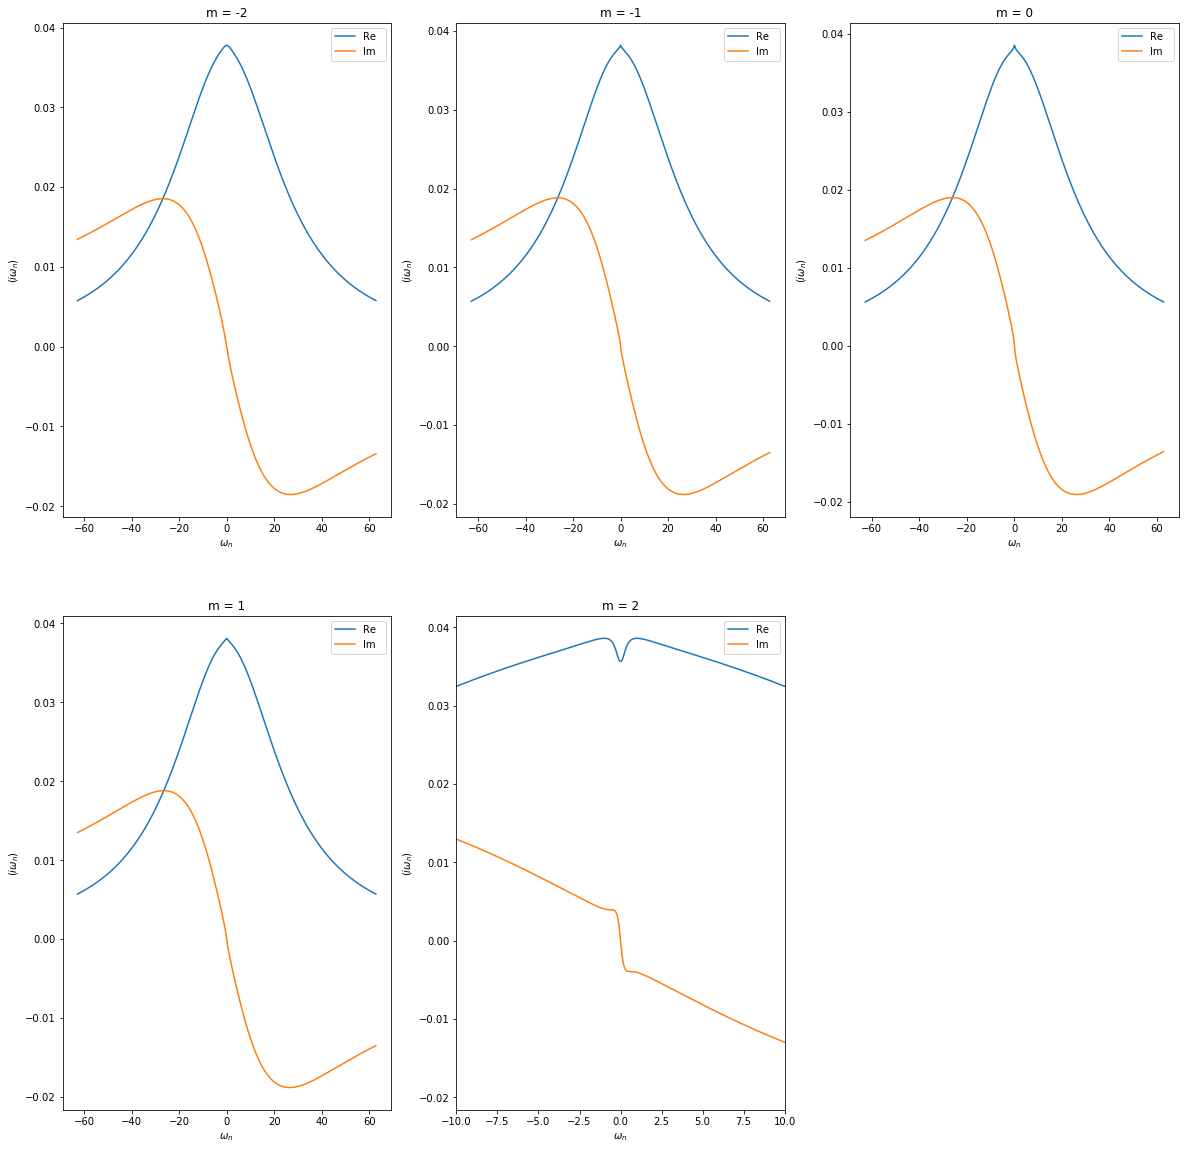

In [31]:
from pytriqs.plot.mpl_interface import oplot
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in range(norb) :
    plt.subplot(2,3,i+1)
    plt.title('m = '+str(i -norb/2))
    oplot(G0loc[0,i,i])
plt.xlim(-10,10)
plt.show()